Dataset Shape: (3649, 21)



--- Top 5 Countries by CO2 Emissions ---
       Entity  CO2 Emissions (kt)
United States           5775810.0
        China           3346530.0
        Japan           1182610.0
        India            937860.0
      Germany            830280.0

--- Top 5 Countries by Renewable Energy Share ---
    Entity  Renewable energy share in the total final energy consumption (%)
  Ethiopia                                                             95.55
    Uganda                                                             95.01
Mozambique                                                             93.64
   Somalia                                                             93.28
   Burundi                                                             93.23

--- Top 5 Countries by GDP per Capita ---
       Entity  gdp_per_capita
   Luxembourg     48538.78290
        Japan     39169.35957
  Switzerland     38952.03420
       Norway     38131.46061
United States     36334.90878

--- Top 5 Countri

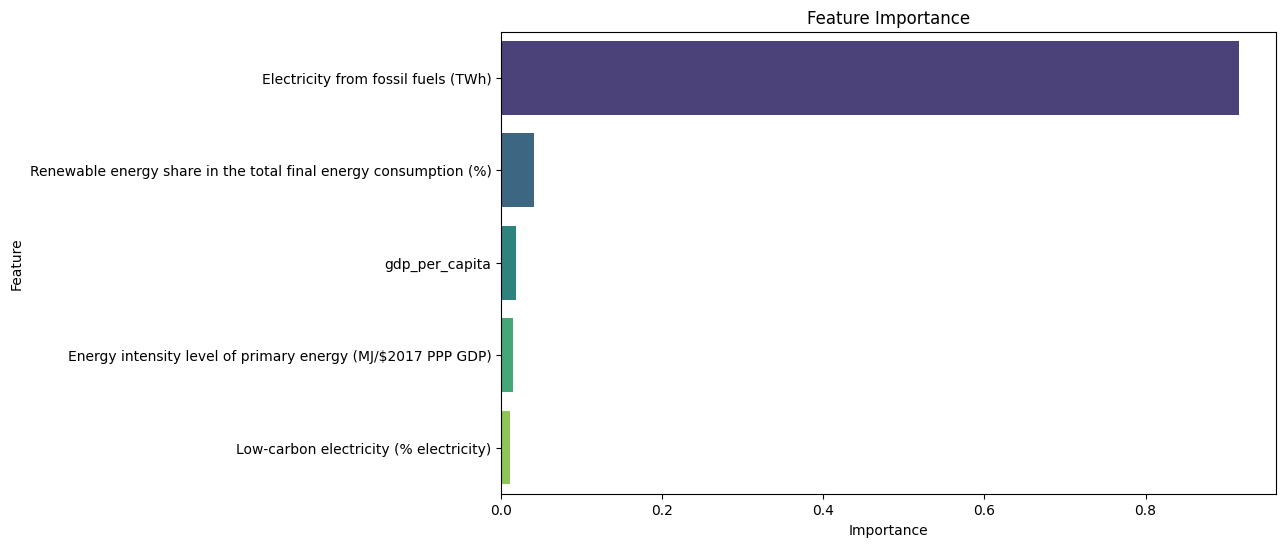

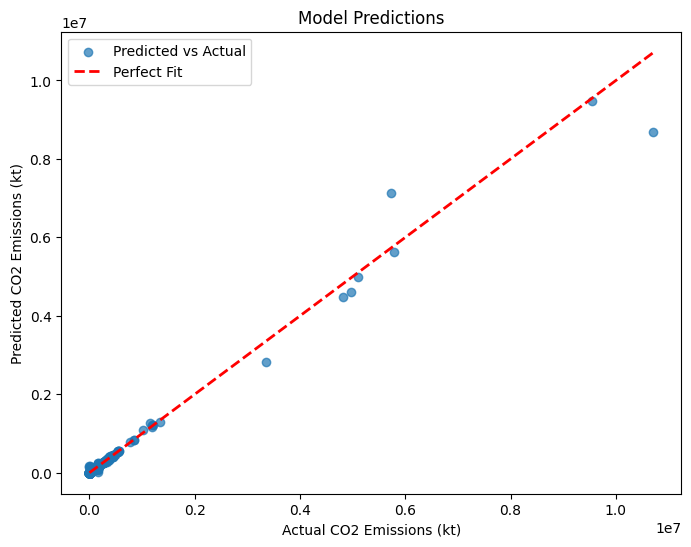

Model and scaler saved.


In [30]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import warnings
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
import joblib

warnings.filterwarnings("ignore")

# Load and Prepare Data
df = pd.read_csv('/content/global.csv')
print("Dataset Shape:", df.shape)

# Data Cleaning (Simplified)
columns_to_drop = ['Financial flows to developing countries (US $)',
                   'Renewables (% equivalent primary energy)',
                   'Renewable-electricity-generating-capacity-per-capita']
df.drop(columns=columns_to_drop, inplace=True)

columns_to_fill_mean = ['Access to clean fuels for cooking',
                        'Renewable energy share in the total final energy consumption (%)',
                        'Electricity from nuclear (TWh)',
                        'Energy intensity level of primary energy (MJ/$2017 PPP GDP)',
                        'Value_co2_emissions_kt_by_country',
                        'gdp_growth', 'gdp_per_capita']
df[columns_to_fill_mean] = df[columns_to_fill_mean].fillna(df[columns_to_fill_mean].mean())
df.dropna(inplace=True)

df.rename(columns={
    "Value_co2_emissions_kt_by_country": "CO2 Emissions (kt)",
    "Land Area(Km2)": "Land Area (km²)",
    "Density\\n(P/Km2)": "Density (P/km²)"
}, inplace=True)
df['Density (P/km²)'] = df['Density (P/km²)'].str.replace(',', '').astype(float)


# Bubble chart: Electricity Access vs Renewable Energy
fig = px.scatter(df, x='Access to electricity (% of population)',
                 y='Renewable energy share in the total final energy consumption (%)',
                 size='gdp_per_capita', color='Entity', hover_name='Entity',
                 title='Electricity Access vs Renewable Energy',
                 labels={'Access to electricity (% of population)':'Access (%)',
                         'Renewable energy share in the total final energy consumption (%)':'Renewable Share (%)',
                         'gdp_per_capita':'GDP per Capita'})
fig.update_layout(width=900, height=600)
fig.show()


# Animated scatter: Fossil Fuels vs CO2 over time
fig = px.scatter(df, x='Electricity from fossil fuels (TWh)', y='CO2 Emissions (kt)',
                 color='Renewable energy share in the total final energy consumption (%)',
                 size='Primary energy consumption per capita (kWh/person)',
                 hover_name='Entity', animation_frame='Year',
                 title='Fossil Fuel Use vs CO2 Emissions Over Time',
                 labels={'Electricity from fossil fuels (TWh)':'Fossil Fuel (TWh)',
                         'CO2 Emissions (kt)':'CO2 (kt)',
                         'Renewable energy share in the total final energy consumption (%)':'Renewable Share (%)',
                        'Primary energy consumption per capita (kWh/person)':'Energy Use/Capita'},
                 color_continuous_scale='Viridis')
fig.update_layout(xaxis_type="log", yaxis_type="log", width=900, height=600)
fig.show()


# Bubble chart: Energy Intensity vs GDP
fig = px.scatter(df, x='gdp_per_capita',
                 y='Energy intensity level of primary energy (MJ/$2017 PPP GDP)',
                 size='Renewable energy share in the total final energy consumption (%)',
                 color='Renewable energy share in the total final energy consumption (%)',
                 hover_name='Entity',
                 title='Energy Intensity vs GDP per Capita',
                 labels={'gdp_per_capita':'GDP per Capita',
                         'Energy intensity level of primary energy (MJ/$2017 PPP GDP)':'Energy Intensity (MJ/$)',
                         'Renewable energy share in the total final energy consumption (%)':'Renewable Share (%)'},
                 color_continuous_scale='Viridis')
fig.update_layout(width=900, height=600)

fig.show()

# Key Statistics (Top Countries)
def show_top_countries(df, column, title, n=5):
    top_countries = (df.drop_duplicates(subset=['Entity']).nlargest(n, column))
    print(f"\n--- Top {n} Countries by {title} ---")
    print(top_countries[['Entity', column]].to_string(index=False))

show_top_countries(df, 'CO2 Emissions (kt)', 'CO2 Emissions')
show_top_countries(df, 'Renewable energy share in the total final energy consumption (%)', 'Renewable Energy Share')
show_top_countries(df, 'gdp_per_capita', 'GDP per Capita')
show_top_countries(df, 'Energy intensity level of primary energy (MJ/$2017 PPP GDP)', 'Energy Intensity')

# Modeling (Simplified)
features = [
    'gdp_per_capita',
    'Energy intensity level of primary energy (MJ/$2017 PPP GDP)',
    'Renewable energy share in the total final energy consumption (%)',
    'Electricity from fossil fuels (TWh)',
    'Low-carbon electricity (% electricity)'
]
target = 'CO2 Emissions (kt)'
df_model = df[features + [target]].dropna()

X = df_model[features]
y = df_model[target]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Random Forest Model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
y_pred = rf_model.predict(X_test)
r2 = r2_score(y_test, y_pred)
print(f"\nRandom Forest R²: {r2:.2f}")

# Feature Importance Visualization
feature_importances = pd.DataFrame({'Feature': X.columns, 'Importance': rf_model.feature_importances_})
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importances, palette='viridis')
plt.title('Feature Importance')
plt.savefig("feature_importance.png", bbox_inches='tight', dpi=300)
plt.show()


# Actual vs Predicted Scatter Plot
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.7, label='Predicted vs Actual')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2, label='Perfect Fit')
plt.xlabel('Actual CO2 Emissions (kt)')
plt.ylabel('Predicted CO2 Emissions (kt)')
plt.title('Model Predictions')
plt.legend()
plt.savefig("actual_vs_predicted.png", bbox_inches='tight', dpi=300)
plt.show()

# Save model and scaler
joblib.dump(rf_model, 'rf_model.pkl')
joblib.dump(scaler, 'scaler.pkl')
print("Model and scaler saved.")